<h1><center>Deep Learning </center></h1>
 <h1><center> Homework 1- Flore Sentenac</center></h1>
 
 
 
 
 
 
 ## Some tools and installations

In [77]:
#@title
!pip install torchvision
!pip install keras

Code provided for the homework copied in the cell bellow

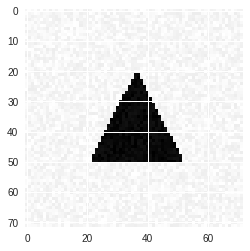

In [78]:
#@title
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



#1- Simple Classification

Building and training a linear classifier in Keras to classify a image into one of the three possible
categories (i.e. rectangle, disk, triangle) with centered shapes.

#### Create the training data

In [79]:
from keras.utils import np_utils
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train, 3)

Creating data:
0
100
200


### SGD optimizer


In [80]:
from keras.models import Sequential
from keras.layers import Dense, Activation

# Build model
model_sgd = Sequential()
model_sgd.add(Dense(input_dim=72*72, output_dim=3, activation="softmax"))
# Choose optimizer loss and metrics
model_sgd.compile(loss='categorical_crossentropy', optimizer='sgd')
#fit model
model_sgd.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  


Epoch 1/15
300/300 [==============================] - 5s 16ms/step - loss: 9.0430
Epoch 2/15
300/300 [==============================] - 0s 199us/step - loss: 10.8529
Epoch 3/15
300/300 [==============================] - 0s 198us/step - loss: 10.8529
Epoch 4/15
300/300 [==============================] - 0s 212us/step - loss: 10.8529
Epoch 5/15
300/300 [==============================] - 0s 253us/step - loss: 10.8529
Epoch 6/15
300/300 [==============================] - 0s 209us/step - loss: 10.8529
Epoch 7/15
300/300 [==============================] - 0s 203us/step - loss: 10.8529
Epoch 8/15
300/300 [==============================] - 0s 198us/step - loss: 10.8529
Epoch 9/15
300/300 [==============================] - 0s 244us/step - loss: 10.8529
Epoch 10/15
300/300 [==============================] - 0s 202us/step - loss: 10.8529
Epoch 11/15
300/300 [==============================] - 0s 207us/step - loss: 10.8529
Epoch 12/15
300/300 [==============================] - 0s 270us/step - loss:

#### Results with the SGD optimizer

In [81]:
#test if the classifier is correct in the absence of noise
X_test,t = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
print("finds triangles", model_sgd.predict(X_test)[0][2] == 1)

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print("finds disks", model_sgd.predict(X_test)[0][1] == 1)

X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
print("finds rectangles", model_sgd.predict(X_test)[0][0] == 1)

finds triangles False
finds disks False
finds rectangles True


### Adam optimizer

In [82]:
# Build model
model_adam = Sequential()
model_adam.add(Dense(input_dim=72*72, output_dim=3, activation="softmax"))
# Choose optimizer loss and metrics
model_adam.compile(loss='categorical_crossentropy', optimizer='adam')
#fit model
model_adam.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  


Epoch 1/15
300/300 [==============================] - 5s 16ms/step - loss: 1.6036
Epoch 2/15
300/300 [==============================] - 0s 214us/step - loss: 0.9162
Epoch 3/15
300/300 [==============================] - 0s 235us/step - loss: 0.7199
Epoch 4/15
300/300 [==============================] - 0s 242us/step - loss: 0.5352
Epoch 5/15
300/300 [==============================] - 0s 235us/step - loss: 0.3936
Epoch 6/15
300/300 [==============================] - 0s 237us/step - loss: 0.2757
Epoch 7/15
300/300 [==============================] - 0s 215us/step - loss: 0.2404
Epoch 8/15
300/300 [==============================] - 0s 231us/step - loss: 0.2039
Epoch 9/15
300/300 [==============================] - 0s 269us/step - loss: 0.2142
Epoch 10/15
300/300 [==============================] - 0s 215us/step - loss: 0.1723
Epoch 11/15
300/300 [==============================] - 0s 238us/step - loss: 0.1705
Epoch 12/15
300/300 [==============================] - 0s 247us/step - loss: 0.1583
Ep

#### Results with the Adam optimizer

In [83]:
#test if the classifier is correct in the absence of noise
X_test,t = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
print("finds triangles", model_adam.predict(X_test)[0][2] == 1)

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print("finds disks", model_adam.predict(X_test)[0][1] == 1)

X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
print("finds rectangles", model_adam.predict(X_test)[0][0] == 1)

finds triangles True
finds disks True
finds rectangles True


#### Visualization of the solution

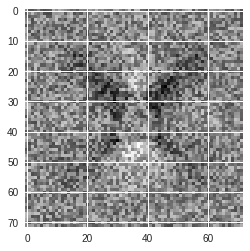

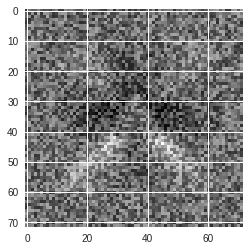

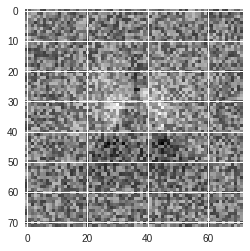

In [84]:
weights, t = model_adam.get_weights()
w_1 = weights[:,0] + t[0]
plt.imshow(w_1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
w_2 = weights[:,1] + t[1]
plt.imshow(w_2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
w_3 = weights[:,2] + t[2]
plt.imshow(w_3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### Comment:
In this case the Adam optimizer yields far better results

# 2- More complicated

We will know allow the locations to vary

In [85]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train, 3)

Creating data:
0
100
200


In [86]:
# Build model
model_adam = Sequential()
model_adam.add(Dense(input_dim=72*72, output_dim=3, activation="softmax"))
# Choose optimizer loss and metrics
model_adam.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#fit model
model_adam.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  


Epoch 1/15
300/300 [==============================] - 5s 16ms/step - loss: 2.2177 - acc: 0.3433
Epoch 2/15
300/300 [==============================] - 0s 237us/step - loss: 1.9788 - acc: 0.3933
Epoch 3/15
300/300 [==============================] - 0s 232us/step - loss: 1.2911 - acc: 0.4333
Epoch 4/15
300/300 [==============================] - 0s 247us/step - loss: 1.0082 - acc: 0.4733
Epoch 5/15
300/300 [==============================] - 0s 231us/step - loss: 1.0307 - acc: 0.4600
Epoch 6/15
300/300 [==============================] - 0s 243us/step - loss: 0.9608 - acc: 0.5100
Epoch 7/15
300/300 [==============================] - 0s 278us/step - loss: 1.0008 - acc: 0.5233
Epoch 8/15
300/300 [==============================] - 0s 245us/step - loss: 0.8893 - acc: 0.5433
Epoch 9/15
300/300 [==============================] - 0s 233us/step - loss: 0.8867 - acc: 0.5433
Epoch 10/15
300/300 [==============================] - 0s 235us/step - loss: 0.9541 - acc: 0.5533
Epoch 11/15
300/300 [=========

### Results of the linear classifier

In [87]:
[X_test, Y_test] = generate_test_set_classification()
print(model_adam.metrics_names)
model_adam.evaluate(X_test, Y_test)


Creating data:
0
100
200
['loss', 'acc']
300/300 [==============================] - 2s 7ms/step


[0.8674802978833517, 0.5899999996026357]

In [88]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Flatten

# Build model
small_cnn = Sequential()
small_cnn.add(Conv2D(16, (5,5), activation="relu", input_shape=(72, 72, 1)))
small_cnn.add(MaxPooling2D(pool_size=(2, 2)))
small_cnn.add(Flatten())
small_cnn.add(Dense(input_dim=34*34*16, output_dim=3, activation="softmax", init="normal"))

# Choose optimizer loss and metrics
small_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#fit model
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train = np_utils.to_categorical(Y_train, 3)
X_train = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_train])
small_cnn.fit(X_train, Y_train, batch_size=32, epochs=20, verbose=1)

Creating data:
0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=18496, activation="softmax", units=3, kernel_initializer="normal")`
  if __name__ == '__main__':


100
200
300
400
500
600
700
800
900
Epoch 1/20
1000/1000 [==============================] - 5s 5ms/step - loss: 1.0880 - acc: 0.4870
Epoch 2/20
1000/1000 [==============================] - 0s 358us/step - loss: 0.7676 - acc: 0.7060
Epoch 3/20
1000/1000 [==============================] - 0s 359us/step - loss: 0.6293 - acc: 0.7460
Epoch 4/20
1000/1000 [==============================] - 0s 349us/step - loss: 0.5595 - acc: 0.7890
Epoch 5/20
1000/1000 [==============================] - 0s 355us/step - loss: 0.5016 - acc: 0.8230
Epoch 6/20
1000/1000 [==============================] - 0s 343us/step - loss: 0.4426 - acc: 0.8360
Epoch 7/20
1000/1000 [==============================] - 0s 347us/step - loss: 0.4022 - acc: 0.8690
Epoch 8/20
1000/1000 [==============================] - 0s 353us/step - loss: 0.3813 - acc: 0.8800
Epoch 9/20
1000/1000 [==============================] - 0s 342us/step - loss: 0.3518 - acc: 0.8870
Epoch 10/20
1000/1000 [==============================] - 0s 346us/step - lo

### Results of the small CNN

In [89]:
[X_test, Y_test] = generate_test_set_classification()
X_test = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_test])
print(small_cnn.metrics_names)
small_cnn.evaluate(X_test, Y_test)


Creating data:
0
100
200
['loss', 'acc']
300/300 [==============================] - 2s 8ms/step


[0.44228077252705894, 0.806666665871938]

# 3- A Regression problem

We want to locate the angles of triangles.
To do so, we need to differentiate the angles from one another (otherwise we won't be able to train the network).
I chose to order the summits allong their x coordinate.

In [0]:
def reorder_angles(y):
  new_y = y
  if y[2]<y[0] and y[0]<y[4]:#102
    new_y = y[[2,3,0,1,4,5]]
  if y[4]<y[2] and y[2]<y[0]:#210
    new_y = y[[4,5,2,3,0,1]]
  if y[2] < y[4] and y[4]<y[0]:#120
    new_y = y[[2,3,4,5,0,1]]
  if y[0] < y[4] and y[4]<y[2]:#021
    new_y = y[[0,1,4,5,2,3]]
  if y[2] < y[4] and y[4]<y[0]:#120
    new_y = y[[2,3,4,5,0,1]]
  if y[4] < y[2] and y[0]<y[2]:#201
    new_y = y[[4,5,0,1,2,3]]
  return new_y
    

In [91]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Flatten
from keras.optimizers import Adam

# Build model
cnn_reg = Sequential()
cnn_reg.add(Conv2D(32, (5,5), activation="relu", input_shape=(72, 72, 1)))
cnn_reg.add(MaxPooling2D(pool_size=(2, 2)))
cnn_reg.add(Conv2D(64, (5,5), activation="relu", input_shape=(36, 36, 32)))
cnn_reg.add(MaxPooling2D(pool_size=(2, 2)))
cnn_reg.add(Conv2D(128, (5,5), activation="relu", input_shape=(18, 18, 64)))
cnn_reg.add(MaxPooling2D(pool_size=(2, 2)))
cnn_reg.add(Conv2D(256, (5,5), activation="relu", input_shape=(9, 9, 64)))
cnn_reg.add(Flatten())
cnn_reg.add(Dense(input_dim=9*9*128, output_dim=128, activation="relu", init="normal"))
cnn_reg.add(Dense(input_dim=128, output_dim=6, activation="relu", init="normal"))

adam = Adam(lr=0.001)
# Choose optimizer loss and metrics
cnn_reg.compile(loss='mean_squared_error', optimizer= adam, metrics=['accuracy'])

#fit model
[X_train, Y_train] = generate_dataset_regression(2000, 20)
Y_train = np.array([reorder_angles(y) for y in Y_train])
X_train = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_train])
cnn_reg.fit(X_train, Y_train, batch_size=64, epochs=50, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=10368, activation="relu", units=128, kernel_initializer="normal")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=128, activation="relu", units=6, kernel_initializer="normal")`
  app.launch_new_instance()


Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Epoch 1/50
2000/2000 [==============================] - 7s 3ms/step - loss: 0.2537 - acc: 0.1450
Epoch 2/50
2000/2000 [==============================] - 1s 596us/step - loss: 0.2032 - acc: 0.1760
Epoch 3/50
2000/2000 [==============================] - 1s 605us/step - loss: 0.1973 - acc: 0.1725
Epoch 4/50
2000/2000 [==============================] - 1s 602us/step - loss: 0.0951 - acc: 0.3830
Epoch 5/50
2000/2000 [==============================] - 1s 599us/step - loss: 0.0408 - acc: 0.5465
Epoch 6/50
2000/2000 [==============================] - 1s 607us/step - loss: 0.0320 - acc: 0.5995
Epoch 7/50
2000/2000 [==============================] - 1s 603us/step - loss: 0.0280 - acc: 0.6410
Epoch 8/50
2000/2000 [==============================] - 1s 612us/step - loss: 0.0254 - acc: 0.6700
Epoch 9/50
2000/2000 [==============================] - 1s 612us/step - loss: 0.0233 - acc: 0.6900
Epoch 10

### Results

In [92]:
[X_test, Y_test] = generate_test_set_regression()
Y_test = np.array([reorder_angles(y) for y in Y_test])
X_test = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_test])
print(cnn_reg.metrics_names)
cnn_reg.evaluate(X_test, Y_test)

Creating data:
0
100
200
['loss', 'acc']
300/300 [==============================] - 2s 8ms/step


[0.023510596578319866, 0.7433333333333333]

In [0]:
def visualize_multiple_prediction(list_x, y):
    list_I = [x.reshape((IMAGE_SIZE,IMAGE_SIZE)) for x in list_x]
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    for i in range(1,17):
      ax = fig.add_subplot(4, 4, i)

      ax.imshow(list_I[i-1], extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
      ax.set_xlim([0,1])
      ax.set_ylim([0,1])

      xy = y[i-1].reshape(3,2)
      tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
      ax.add_patch(tri)

    plt.show()

Plot of the results on part of the test data

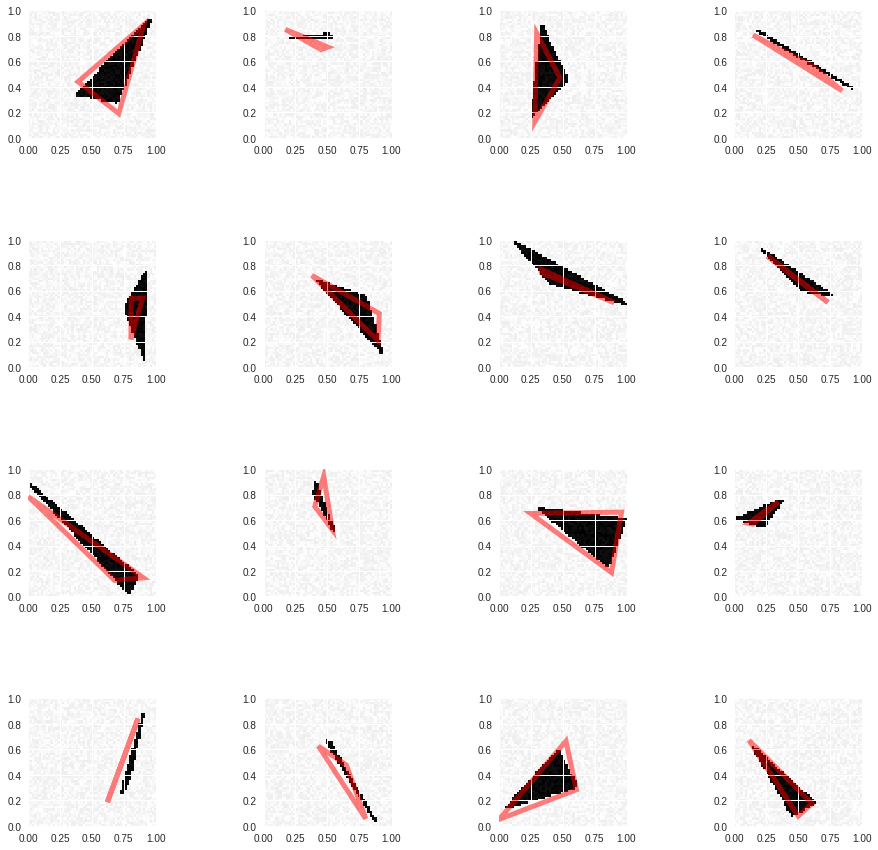

In [94]:
Y_predict = cnn_reg.predict(X_test)

visualize_multiple_prediction(X_test[0:16], Y_predict[0:16])


# 4 - Image denoising

In [0]:
def generate_a_rectangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, 0.0), generate_a_drawing(figsize, U, V, noise)


def generate_a_disk_denoising(noise=0.0, free_location=True):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, 0.0), generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle_denoising(noise=0.0, free_location=True):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, 0.0), generate_a_drawing(figsize, U, V, noise)


def generate_dataset_denoising(nb_samples, noise=0.0, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X_noisy = np.zeros([nb_samples,im_size])
    X_perfect = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X_perfect[i], X_noisy[i] = generate_a_rectangle_denoising(noise, free_location)
        elif category == 1: 
            X_perfect[i], X_noisy[i] = generate_a_disk_denoising(noise, free_location)
        else:
            X_perfect[i], X_noisy[i] = generate_a_triangle_denoising(noise, free_location)

    X_noisy = (X_noisy + noise) / (255 + 2 * noise)
    return [X_perfect, X_noisy]

Creating data:
0


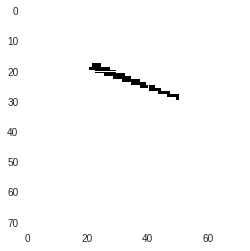

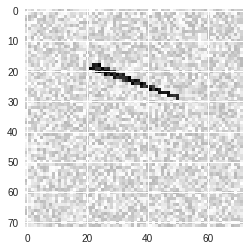

In [96]:
X_perfect, X_noisy = generate_dataset_denoising(100, noise=100.0)
X_perfect = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_perfect])
X_noisy = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_noisy])

plt.imshow(X_perfect[1,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_noisy[1,:,:,0], cmap='gray')

In [0]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, UpSampling2D

# Build model
hourglass_cnn = Sequential()
hourglass_cnn.add(Conv2D(32, (3,3), activation="relu", input_shape=(72, 72, 1), padding = "same"))
hourglass_cnn.add(MaxPooling2D(pool_size=(2, 2)))
hourglass_cnn.add(Conv2D(64, (3,3), activation="relu", input_shape=(36, 36, 32), padding = "same"))
hourglass_cnn.add(Conv2D(32, (3,3), activation="relu", input_shape=(36, 36, 64), padding = "same"))
hourglass_cnn.add(UpSampling2D(size=(2, 2)))
hourglass_cnn.add(Conv2D(1, (3,3), activation="relu", input_shape=(72, 72, 32), padding = "same"))

In [98]:
hourglass_cnn.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_302 (Conv2D)          (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_303 (Conv2D)          (None, 36, 36, 64)        18496     
_________________________________________________________________
conv2d_304 (Conv2D)          (None, 36, 36, 32)        18464     
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_305 (Conv2D)          (None, 72, 72, 1)         289       
Total params: 37,569
Trainable params: 37,569
Non-trainable params: 0
_________________________________________________________________


In [99]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, UpSampling2D, Conv2DTranspose
from keras.layers.merge import concatenate, add
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential
# Build U-Net model
inputs = Input((72, 72, 1))

c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu',padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
"""
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid', output_padding=(1,1)) (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

"""
u7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same') (c4)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='relu') (c9)

u_net = Model(inputs=[inputs], outputs=[outputs])
u_net.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
u_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_306 (Conv2D)             (None, 72, 72, 16)   160         input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_307 (Conv2D)             (None, 72, 72, 16)   2320        conv2d_306[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_90 (MaxPooling2D) (None, 36, 36, 16)   0           conv2d_307[0][0]                 
__________________________________________________________________________________________________
conv2d_308

In [100]:
X_perfect, X_noisy = generate_dataset_denoising(5000, noise=100.0)
X_perfect = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_perfect])
X_noisy = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_noisy])

adam = Adam(lr=0.001, decay=0.0001)
# Choose optimizer loss and metrics
u_net.compile(loss='mean_squared_error', optimizer= adam, metrics=['accuracy'])

#fit model

u_net.fit(X_noisy, X_perfect, batch_size=64, epochs=100, verbose=1)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
Epoch 1/100
5000/5000 [==============================] - 15s 3ms/step - loss: 34572.5140 - acc: 0.0082
Epoch 2/100
5000/5000 [==============================] - 9s 2ms/step - loss: 4007.8615 - acc: 0.0143
Epoch 3/100
5000/5000 [==============================] - 9s 2ms/step - loss: 619.4072 - acc: 0.1112
Epoch 4/100
5000/5000 [==============================] - 9s 2ms/step - loss: 307.3860 - acc: 0.1604
Epoch 5/100
5000/5000 [==============================] - 9s 2ms/step - loss: 249.5294 - acc: 0.1538
Epoch 6/100
5000/5000 [==============================] - 9s 2ms/step - loss: 175.0371 - acc: 0.1914
Epoch 7/100
5000/5000 [==============================] - 9s 2ms/step - loss: 145.4048 - acc: 0.1813
Epoch 8/100
5000/5000 [====================

Creating data:
0


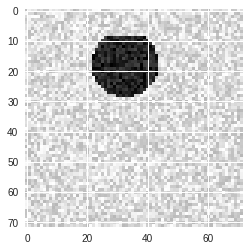

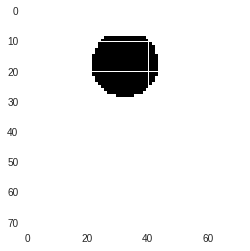

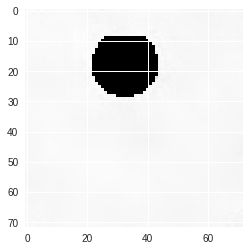

In [101]:
X_perfect_test, X_noisy_test = generate_dataset_denoising(10, noise=100.0)
X_perfect_test = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_perfect_test])
X_noisy_test = np.array([x.reshape(IMAGE_SIZE,IMAGE_SIZE,1) for x in X_noisy_test])
X_predict = u_net.predict(X_noisy_test)

plt.imshow(X_noisy_test[1,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_perfect_test[1,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_predict[1,:,:,0], cmap='gray')

I have tried a simple hourglass network and a u-net. The u-net yields better results, however the background never goes fully white. This could be fixed with some post-processing.